In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import rtbm.layers as layers
import rtbm.model as mdl

import warnings
warnings.filterwarnings('ignore')

from rtbm.costfunctions import mse, logarithmic
from rtbm import minimizer

from rtbm.activations import tanh, linear, sigmoid
from rtbm.mathtools import theta_1d, logtheta_1d_phaseI
from rtbm.riemann_theta.riemann_theta import RiemannTheta
from rtbm.gradientschemes import RMSprop, adam, adadelta, adagrad

from rtbm.initializers import uniform

import rtbm.layers as layers
import rtbm.model as mdl

from rtbm import RTBM

from numpy import frompyfunc

## RTBM grad descent test

[[1]]


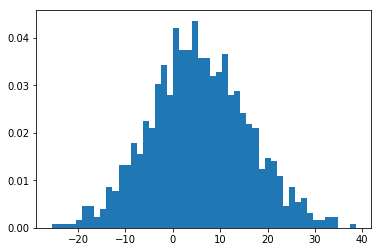

In [2]:
# simple gaussian
n = 1000
data = (np.random.normal(5,10,n)).reshape(1,n)
plt.hist(data.T, bins=50, normed=True);

M = mdl.Model()
M.add(layers.ThetaUnitLayer(1,1,1,diagonal_T=True))


In [3]:
data[:,1].reshape((1,1))

array([[1.70186281]])

In [4]:
M.get_parameters()
M.gradient_check(0,data[:,1].reshape((1,1)),0.01)

('I: ', array([[1.70186281]]))
('P: ', array([ 0.52665928, -0.08107559,  0.        ,  0.00752462,  0.44380091]))
('O: ', array([[1.36878604e-18]]))
0 th (mean) numerical gradient: 
[-2.6214877e-16]
('X:', array([[1.70186281]]))
('iT:', array([[132.89714906]]))
('iTW:', array([[0.]]))
('W:', array([[0.]]))
('Da:', (-0.1826845973464113-0j))
('Db:', (-0.1826845973464113-0j))
('P: ', array([[1.36878604e-18+0.j]]))
('gradBh: ', array([[0.+0.j]]))
('gradBv: ', array([[0.+0.j]]))


AttributeError: 'int' object has no attribute 'flatten'

In [ ]:
minim = minimizer.SGD()
solution = minim.train(logarithmic, a, data, maxiter=100)

# Derivatives test

In [ ]:
Q=np.zeros((1,1), dtype=complex)
V=np.zeros((1,1), dtype=complex)
V[0,0]=0.1*2j*np.pi
Q[0,0]=0.01*2*np.pi

#print(theta_1d(V,Q,0))


print(RiemannTheta(V/(2j*np.pi),1j*Q/(2*np.pi), derivs=[[1],[1]]))

#print(RiemannTheta(V/(2j*np.pi),1j*Q/(2*np.pi), derivs=[[1],[1]]))

#mpmath.jtheta(3,V[0,0],Q[0,0])

In [ ]:
X=np.random.uniform(-50, 50,(1000,1))

In [ ]:
%%time
t = RiemannTheta(X/(2j*np.pi),1j*Q/(2*np.pi))

In [ ]:
Q=np.zeros((1,1), dtype=float)
V=np.zeros((1,1), dtype=float)
V[0,0]=0.1
Q[0,0]=0.01


print(theta_1d(V,Q,0))
print(np.exp(logtheta_1d_phaseI(V,Q,0)))

print(RiemannTheta(V/(2j*np.pi),-1*Q/(2j*np.pi)))

# Linear layer test

In [ ]:
def funcA(x):
    return 0.6-0.3*x

def funcB(x):
    return -0.5+0.8*x


def func(x1,x2):
    return 0.6-0.3*x1+1.2*x2

X1 = np.linspace(-5.3, 5, 997)
X2 = np.linspace(-5.5, 5, 997)

X = np.stack((X1,X2))

#Y = func(X1,X2).reshape((1,X.shape[1]))
Y = np.stack((funcA(X1),funcB(X2)))

M = mdl.Model()
M.add(layers.Linear(2,2))

#minim = minimizer.CMA(True)
#minim.train(mse(), M, X, Y, tolfun=1e-3)

M = mdl.Model()
M.add(layers.Linear(2,1))
M.add(layers.Linear(1,2))


minim = minimizer.SGD()
minim.train(mse(), M, X, Y, maxiter=300,batch_size=98)

# E(h|v) SGD test

## Phase I

In [ ]:
def func(x):
    return np.sin(x)+x

X = np.linspace(-3.5, 5, 998)
X = X.reshape((1,X.shape[0]))

Y = func(X[:,None]).reshape((1,X.shape[1]))

M = mdl.Model()

M.add(layers.DiagExpectationUnitLayer(1,3, phase=1j, Q_init=uniform(2,3+1e-5)))
M.add(layers.DiagExpectationUnitLayer(3,1, phase=1j, Q_init=uniform(2,3+1e-5)))

#M.add(layers.DiagExpectationUnitLayer(3,1, phase=1))


In [ ]:

#print(M.get_parameters())
M.gradient_check(13,X,0.01)

In [ ]:
minim = minimizer.SGD()

minim.train(mse(), M, X, Y, lr=0.01,maxiter=1000)

plt.plot(X.flatten(), Y.flatten(),"og-", label='fit')
plt.plot(X.flatten(), np.real(M.predict(X)).flatten(),"ob-", label='fit')

## Phase II

In [ ]:
def func(x):
    return np.sin(x)

X = np.linspace(-5, 5, 997)
X = X.reshape((1,X.shape[0]))

Y = func(X[:,None]).reshape((1,X.shape[1]))

M = mdl.Model()
M.add(layers.DiagExpectationUnitLayer(1,3, phase=1j, Q_init=uniform(2,3+1e-5)))
M.add(layers.DiagExpectationUnitLayer(3,1, phase=1j, Q_init=uniform(2,3+1e-5)))

print("*** init ***")
print(M.get_layer(1)._q)
print(M.get_layer(2)._q)

minim = minimizer.SGD()

minim.train(mse(), M, X, Y, lr=0.1, scheme=RMSprop(), maxiter=500)

plt.plot(X.flatten(), Y.flatten(),"og-", label='fit')
plt.plot(X.flatten(), np.real(M.predict(X)).flatten(),"ob-", label='fit')

In [ ]:
print(M.get_layer(1)._q)
print(M.get_layer(2)._q)


## CMA

In [ ]:
M = mdl.Model()
M.add(layers.DiagExpectationUnitLayer(1,3,phase=1))
M.add(layers.DiagExpectationUnitLayer(3,1,phase=1))

minim = minimizer.CMA()

minim.train(mse(), M, X, Y, maxiter=500)
plt.plot(X.flatten(), Y.flatten(),"og-", label='fit')
plt.plot(X.flatten(), np.real(M.predict(X)).flatten(),"ob-", label='fit')

In [ ]:
def func(x1,x2):
    return 0.2*x1+0.4*x2+0.8

X1 = np.linspace(-5.3, 5, 1000)
X2 = np.linspace(-5.5, 5, 1000)

X = np.stack((X1,X2))

Y = func(X1[:,None],X2[:,None]).reshape((1,X1.shape[0]))

M = mdl.Model()
M.add(layers.DiagExpectationUnitLayer(2,1))
M.add(layers.DiagExpectationUnitLayer(1,1))


minim = minimizer.SGD()
minim.train(mse(), M, X, Y, lr=0.1,maxiter=400)

#plt.plot(X.flatten(), Y.flatten(),"og-", label='fit')
#plt.plot(X.flatten(), np.real(M.predict(X)).flatten(),"ob-", label='fit')

# Layer test

In [ ]:
M = mdl.Model()
M.add(layers.DiagExpectationUnitLayer(1,3))
M.add(layers.DiagExpectationUnitLayer(3,1))

In [ ]:
def func(x):
    return np.sin(x)

X = np.linspace(0, 10, 5)
X = X.reshape((1,X.shape[0]))

Y = func(X[:,None]).reshape((1,X.shape[1]))

In [ ]:
plt.plot(X.flatten(), Y.flatten(),"ob-")

In [ ]:
minim = minimizer.CMA(True)
minim.train(mse(), M, X, Y, tolfun=1e-3)

In [ ]:
npoints = 5
test_X = (np.linspace(0, 10, npoints)).reshape((1, npoints))

plt.plot(X.flatten(), Y.flatten(),"og-", label='target')
plt.plot(test_X.flatten(), np.real(M.predict(test_X)).flatten(),"ob-", label='fit')
plt.legend()

# Misc tests

In [ ]:
L = layers.MaxPosLayer(3,1)

In [ ]:
L.feedin(np.array([Y,2*Y,1*Y]).reshape(3,5))

In [ ]:
np.array([Y,2*Y,Y]).reshape(3,5)

In [ ]:
np.empty(0)

In [ ]:
derivative_1d_theta_phaseI([0.1],[1j],0)